# Section 3.1.2: Linear discriminant analysis (LDA)

This page contains simulations in Section 3.1.2.

## Contents

    - Basic settings
    - Empirical evaluation of LDA
    - Theoretical prediction of LDA decision (soft) output


## Basic setting

In [1]:
import numpy as np
import scipy.linalg
from scipy.stats import norm
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist,fashion_mnist

In [2]:
testcase = 'MNIST' # Among 'GMM', 'MNIST' and 'fashion-MNIST'
testcase_option = 'mixed'  # when testcase = 'GMM', among 'mean', 'cov', 'orth' and 'mixed'

coeff = 1
n = 2048*coeff
n_test = 128*coeff
cs = [1/2,1/2]
k = len(cs)

if testcase == 'GMM':
    p = 512*coeff
        
    if testcase_option == 'means': # l = 0 or 1
            means = lambda l : np.mat(np.concatenate([np.zeros(l+1),[1],np.zeros(p-l-2)])*3).T
            #means = lambda l : np.sqrt(2)*(-1)**l*np.concatenate([np.ones(p/2),-1*np.ones(p/2)])/np.sqrt(p)
            covs  = lambda l : np.eye(p)
            
    if testcase_option == 'cov':
            means = lambda l : np.mat(np.zeros(p)).T
            covs  = lambda l : np.eye(p)*(1+l/np.sqrt(p)*15)
            
    if testcase_option == 'orth':
            means = lambda l : np.mat(np.zeros(p)).T
            covs  = lambda l : scipy.linalg.toeplitz( [(4*l/10)**i for i in range(p)] )
    if testcase_option == 'mixed':
            means = lambda l : np.mat(np.concatenate([np.zeros(l+1),[1],np.zeros(p-l-2)])*3).T
            covs  = lambda l : scipy.linalg.toeplitz( [(4*l/10)**i for i in range(p)] )
            #covs  = lambda l : np.eye(p)*(1+l/np.sqrt(p)*15)
            #covs  = lambda l : scipy.linalg.toeplitz( [(4*l/10)**i*(1+l/np.sqrt(p)*4) for i in range(p)] )

if testcase == 'MNIST':
    (init_data, init_labels), _ = mnist.load_data()

if testcase == 'fashion-MNIST':
    (init_data, init_labels), _ = fashion_mnist.load_data()

if testcase in ('MNIST','fashion-MNIST'): # real-world data pre-processing

    idx_init_labels = np.argsort(np.array(init_labels))
    
    labels = init_labels[idx_init_labels]
    init_data = init_data[idx_init_labels,:,:]
    data = np.transpose(init_data.reshape(np.shape(init_data)[0],np.shape(init_data)[1]*np.shape(init_data)[2]))
    init_n,p=np.shape(data)[1],np.shape(data)[0]

    selected_labels=[3,4]

    data = data/data.max()
    mean_data=np.mean(data,axis=1).reshape(len(data),1)
    
    norm2_data=0
    for i in range(init_n):
        norm2_data+=1/init_n*np.linalg.norm(data[:,i]-mean_data)**2

    data=np.mat((data-mean_data)/np.sqrt(norm2_data)*np.sqrt(p))

    selected_data = []
    
    for i in range(len(selected_labels)):
        selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])
        if i==0:    
            cascade_selected_data = selected_data[-1]
        else:
            np.concatenate([cascade_selected_data,selected_data[-1]],axis=1)

    # recentering of the k classes
    mean_selected_data  = np.mean(cascade_selected_data,axis=1).reshape(len(cascade_selected_data),1)
    norm2_selected_data = np.mean(np.sum(np.power(np.abs(cascade_selected_data-mean_selected_data),2)))

    for j in range(len(selected_labels)):
        selected_data[j]=(selected_data[j]-mean_selected_data)/np.sqrt(norm2_selected_data)*np.sqrt(p)

    means = lambda l : np.mean(selected_data[l],axis=1)
    covs  = lambda l : 1/np.shape(selected_data[l])[1]*(selected_data[l]@selected_data[l].T)-means(l)@means(l).T

## Empirical evaluation of LDA

In [3]:
gamma = .1 # regularization parameter

nb_loop = 30
T_store = np.zeros( (n_test,nb_loop) )
accuracy_store = np.zeros(nb_loop)
for data_loop in range(nb_loop):

    if testcase in ('MNIST', 'fashion-MNIST'): # generate data
        X= np.mat(np.zeros( (p,n) ))
        X_test=np.mat(np.zeros( (p,n_test) ))
        for i in range(k): # random data picking
            data = selected_data[i][:,np.random.permutation(np.shape(selected_data[i])[1])]
            X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])]
            X_test[:,int(np.sum(cs[:i])*n_test):int(np.sum(cs[:i+1])*n_test)]=data[:,n:n+int(n_test*cs[i])]
            
    if testcase == 'GMM':
        W= np.mat(np.zeros( (p,n) ))
        W_test=np.mat(np.zeros( (p,n_test) ))
        for i in range(k):
            W[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=scipy.linalg.sqrtm(covs(i))@np.mat(np.random.randn(p,int(cs[i]*n)))
            W_test[:,int(np.sum(cs[:i])*n_test):int(np.sum(cs[:i+1])*n_test)]=scipy.linalg.sqrtm(covs(i))@np.mat(np.random.randn(p,int(cs[i]*n_test)))

        X=np.mat(np.zeros( (p,n) ))
        X_test=np.mat(np.zeros( (p,n_test) ))
        for i in range(k):
            X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=W[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]+means(i-1)
            X_test[:,int(np.sum(cs[:i])*n_test):int(np.sum(cs[:i+1])*n_test)]=W_test[:,int(np.sum(cs[:i])*n_test):int(np.sum(cs[:i+1])*n_test)]+means(i-1)
            
    # run LDA
    X_train0 = X[:,:int(n*cs[0])]
    X_train1 = X[:,int(n*cs[0]):]

    hat_mu0 = np.mean(X_train0,axis=1)
    hat_mu1 = np.mean(X_train1,axis=1)
    hat_mu = np.mat(hat_mu0 + hat_mu1)/2

    P = lambda l : np.mat(np.eye(int(cs[l]*n)) - np.ones( (int(cs[l]*n),int(cs[l]*n)) )/(cs[l]*n))
    hat_C_gamma = ( X_train0 @ P(0) @ X_train0.T + X_train1 @ P(1) @ X_train1.T )/(n-2) + gamma*np.eye(p)

    # decision function
    T = lambda x : np.mat((x - hat_mu).T) @ np.mat(np.linalg.solve(hat_C_gamma,(hat_mu0 - hat_mu1)))
    T_store[:,data_loop] = T(X_test).reshape(len(T_store))

    accuracy_store[data_loop] = np.sum(T(X_test[:,:int(cs[0]*n_test)])>0)/(n_test*cs[0])/2+np.sum(T(X_test[:,int(cs[0]*n_test):])<0)/(n_test*cs[1])/2

T_store0 = T_store[:int(cs[0]*n_test),:]
T_store1 = T_store[int(cs[0]*n_test):,:]

print('Classif accuracy:',np.mean(accuracy_store))

Classif accuracy: 0.9734375


## Theoretical predictions of LDA decision (soft) output

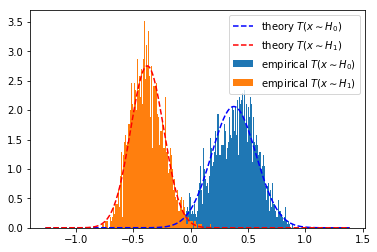

In [4]:
eigs_C = lambda l : np.linalg.eigh(covs(l))[0]

z = - gamma
tilde_g = np.ones(2)
tilde_g_tmp = np.zeros(2)
g = np.zeros(2)

#watch_dog = 1;
while np.sum(np.abs(tilde_g-tilde_g_tmp))>1e-6: #and watch_dog<50
    tilde_g_tmp[:] = tilde_g[:]

    eigs_C_sum = cs[0]*tilde_g[0]*eigs_C(0) + cs[1]*tilde_g[1]*eigs_C(1)

    for a in [0,1]:
        g[a] = -1/z*np.sum( eigs_C(a)/(1 + eigs_C_sum) )/n
        tilde_g[a] = -1/z/(1+g[a])

bar_Q = -1/z*np.linalg.inv( np.eye(p) + cs[0]*tilde_g[0]*covs(0) + cs[1]*tilde_g[1]*covs(1) )

S = gamma**2*np.mat([[cs[0]*tilde_g[0]**2*np.trace( covs(0)*bar_Q @ covs(0) @ bar_Q )/n,cs[1]*tilde_g[0]**2*np.trace( covs(0) @ bar_Q @ covs(1) @ bar_Q )/n],[cs[0]*tilde_g[1]**2*np.trace( covs(0) @ bar_Q @ covs(1) @ bar_Q )/n, cs[1]*tilde_g[1]**2*np.trace( covs(1) @ bar_Q @ covs(1) @ bar_Q )/n]])
tmp_S = np.linalg.inv(np.eye(2) - S) @ S
R = lambda ll,l : cs[ll]/cs[l]*tmp_S[ll,l]

bar_QCQ = lambda l : bar_Q @ covs(l) @ bar_Q + R(0,l)*bar_Q@covs(0)@bar_Q + R(1,l)*bar_Q@covs(1)@bar_Q

delta_mu = np.mat(means(0) - means(1))
theo_mean = lambda l : (-1)**l*delta_mu.T@bar_Q@delta_mu/2 - g[0]/2 + g[1]/2
theo_var  = lambda l : delta_mu.T@bar_QCQ(l)@delta_mu + np.trace(covs(0)@bar_QCQ(l))/(n*cs[0]) + np.trace(covs(1)@bar_QCQ(l))/(n*cs[1])

edges = np.linspace(np.min([T_store0.reshape(np.size(T_store0)),T_store1.reshape(np.size(T_store1))])-.5,np.max([T_store0.reshape(np.size(T_store0)),T_store1.reshape(np.size(T_store1))])+.5,300)

plt.hist(T_store0.reshape(np.size(T_store0)),bins=edges,weights=1/np.size(T_store0)/(edges[1]-edges[0])*np.ones(np.size(T_store0)),label=r'empirical $T(x\sim H_0)$')
plt.hist(T_store1.reshape(np.size(T_store1)),bins=edges,weights=1/np.size(T_store1)/(edges[1]-edges[0])*np.ones(np.size(T_store1)),label=r'empirical $T(x\sim H_1)$')
plt.plot(edges,scipy.stats.norm.pdf(edges, theo_mean(0),np.sqrt(theo_var(0))).reshape(len(edges)),'--b',label=r'theory $T(x\sim H_0)$')
plt.plot(edges,scipy.stats.norm.pdf(edges, theo_mean(1),np.sqrt(theo_var(1))).reshape(len(edges)),'--r',label=r'theory $T(x\sim H_1)$')
_ = plt.legend()